In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xlrd

In [2]:
%pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Skripsi Abdul Hakim/piton skripsi

Mounted at /content/drive
/content/drive/MyDrive/Skripsi Abdul Hakim/piton skripsi


# Read Data

In [4]:
import os

In [5]:
res = []

for path in os.listdir("impute"):
    # check if current path is a file
    if os.path.isfile(os.path.join("impute", path)):
        res.append(path)

res

['impute_stine.pkl',
 'impute_spline.pkl',
 'impute_linear.pkl',
 'impute_nocb.pkl',
 'impute_locf.pkl',
 'impute_simple25.pkl',
 'impute_linear25.pkl',
 'impute_exponential25.pkl']

In [6]:
impute_stine = pd.read_pickle('impute/impute_stine.pkl')
impute_spline = pd.read_pickle('impute/impute_spline.pkl')
impute_linear = pd.read_pickle('impute/impute_linear.pkl')
impute_nocb = pd.read_pickle('impute/impute_nocb.pkl')
impute_locf = pd.read_pickle('impute/impute_locf.pkl')
impute_simple25 = pd.read_pickle('impute/impute_simple25.pkl')
impute_linear25 = pd.read_pickle('impute/impute_linear25.pkl')
impute_exponential25 = pd.read_pickle('impute/impute_exponential25.pkl')



In [22]:
impute_knn = pd.read_pickle('impute/impute_knn.pkl')
impute_knn = fix_format(impute_knn)

In [7]:
def fix_format(dataset):
  dataset = dataset.reset_index()
  dataset['index'] = pd.to_datetime(dataset['index'])
  dataset = dataset.set_index('index')
  dataset = dataset[['gwl', 'rain', 'soil']]

  return dataset

In [8]:
impute_stine         = fix_format(impute_stine)
impute_spline        = fix_format(impute_spline)
impute_linear        = fix_format(impute_linear)

impute_nocb          = fix_format(impute_nocb)
impute_locf          = fix_format(impute_locf)

impute_simple25      = fix_format(impute_simple25)
impute_linear25      = fix_format(impute_linear25)
impute_exponential25 = fix_format(impute_exponential25)

# Convert to Supervised

In [21]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import tensorflow as tf

from math import sqrt
from numpy import concatenate

from keras_tuner import RandomSearch
from keras_tuner import GridSearch
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols= list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    agg = concat(cols, axis=1)
    agg = agg.iloc[:, :-2]
    agg.columns = ['gwl', 'rain', 'soil', 'gwl-1']
    
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [11]:
def min_max_scaling(dataset):
  values   = dataset.values

  scaler   = MinMaxScaler(feature_range=(0,1))
  scaled   = scaler.fit_transform(values)

  reframed = series_to_supervised(scaled, 1, 1)

  values   = reframed.values

  min_gwl_df = dataset['gwl'].min()
  max_gwl_df = dataset['gwl'].max()

  return scaler, values, min_gwl_df, max_gwl_df

In [12]:
def train_test(values):
  n_train = int(19255 * 0.8)
  train = values[:n_train, :]
  test  = values[n_train:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  
  return train_X, train_y, test_X, test_y

In [13]:
def validation_test(model, test_X, test_y, min_gwl_df, max_gwl_df):
  ypred = model.predict(test_X)
  inv_ypred = ypred.flatten()*(max_gwl_df - min_gwl_df) + min_gwl_df

  inv_yact = test_y*(max_gwl_df - min_gwl_df) + min_gwl_df

  rsquare = r2_score(inv_yact, inv_ypred)
  mae = mean_absolute_error(inv_yact, inv_ypred)
  mse = mean_squared_error(inv_yact, inv_ypred)
  rmse = sqrt(mse)

  print('Test RMSE: %.5f' % rmse)
  print('Test R-Squared: %.5f' % rsquare)
  print('Test MAE: %.5f' % mae)
  print('Test MSE: %.5f' % mse)

  df_result = pd.DataFrame({
      'RMSE': rmse,
      'R2': rsquare,
      'MAE': mae,
      'MSE': mse 
  }, index=[0])

  return df_result, inv_ypred, inv_yact

In [14]:
def plot_model(dataset, inv_yact, inv_ypred):
  df_result = pd.DataFrame({
      'date': dataset.index[int(19255 * 0.8)+1:],
      'actual': inv_yact,
      'predicted': inv_ypred
  })

  plt.figure(figsize=(25,10))

  plt.plot(dataset.index, dataset['gwl'])
  plt.plot(df_result['date'], df_result['predicted'], 'b-', label = 'PRED')
  plt.plot(df_result['date'], df_result['actual'], 'r-', label = 'ACT')

  return df_result

In [15]:
def lstm_model_tuning(hp):
  model = Sequential()
  model.add(LSTM(hp.Int('LSTM_1', min_value=40, max_value=90, step=10), return_sequences=True, input_shape=(1,3)))
  model.add(LSTM(hp.Int('LSTM_2', min_value=40, max_value=90, step=10), return_sequences=False))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])

  return model

In [20]:
def lstm_model(unit1, unit2):
  model = Sequential()
  model.add(LSTM(unit1, return_sequences=True, input_shape=(1, 3)))
  model.add(LSTM(unit2, return_sequences=False))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])

  return model

In [17]:
def run_lstm(dataset):
  scaler, values, min, max = min_max_scaling(dataset)

  train_X, train_y, test_X, test_y = train_test(values)

  model = lstm_model()
  history = model.fit(train_X, train_y, epochs=25, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  rsquare, mae, mse, rmse, inv_ypred, inv_yact = validation_test(model, test_X, test_y, min, max)

  result = plot_model(dataset, inv_yact, inv_ypred)

In [18]:
def run_lstm_tuning(dataset, epochs=10, batch_size=64, tuner_name_file='test_tuning_abdul'):
  scaler, values, min, max = min_max_scaling(dataset)

  train_X, train_y, test_X, test_y = train_test(values)

  tuner = GridSearch(
      lstm_model_tuning,
      objective='mse',
      max_trials=25,
      executions_per_trial=1,
      directory='tuner/',
      project_name=tuner_name_file,
      overwrite=True
  )

  tuner.search(
    x=train_X,
    y=train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_X,test_y),
  )

  best_model = tuner.get_best_models(num_models=1)[0]
  best_hp    = tuner.get_best_hyperparameters()[0]
  print(best_hp.values)

  history = best_model.fit(train_X, train_y, epochs=20, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  val_result, inv_ypred, inv_yact = validation_test(best_model, test_X, test_y, min, max)

  result = plot_model(dataset, inv_yact, inv_ypred)

  return best_model, result, val_result

In [19]:
def rerun_model(dataset, model_name, unit1, unit2, epochs=10, batch_size=64,):
  scaler, values, min, max = min_max_scaling(dataset)

  train_X, train_y, test_X, test_y = train_test(values)

  model = tf.keras.models.load_model('SAVE_MODEL/' + model_name)

  history = model.fit(train_X, train_y, epochs=20, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  val_result, inv_ypred, inv_yact = validation_test(best_model, test_X, test_y, min, max)

  result = plot_model(dataset, inv_yact, inv_ypred)

  return result, val_result

SyntaxError: ignored

Epoch 1/25
482/482 - 8s - loss: 0.0061 - mse: 0.0061 - mae: 0.0476 - mape: 17873.9336 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0549 - val_mape: 10.7475 - 8s/epoch - 17ms/step
Epoch 2/25
482/482 - 2s - loss: 0.0055 - mse: 0.0055 - mae: 0.0393 - mape: 7103500.0000 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0521 - val_mape: 10.3008 - 2s/epoch - 4ms/step
Epoch 3/25
482/482 - 2s - loss: 0.0037 - mse: 0.0037 - mae: 0.0337 - mape: 5751081.5000 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0413 - val_mape: 8.0982 - 2s/epoch - 4ms/step
Epoch 4/25
482/482 - 2s - loss: 0.0021 - mse: 0.0021 - mae: 0.0271 - mape: 4226727.0000 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0305 - val_mape: 5.9283 - 2s/epoch - 4ms/step
Epoch 5/25
482/482 - 2s - loss: 0.0010 - mse: 0.0010 - mae: 0.0206 - mape: 2605059.2500 - val_loss: 8.9310e-04 - val_mse: 8.9310e-04 - val_mae: 0.0240 - val_mape: 4.6760 - 2s/epoch - 4ms/step
Epoch 6/25
482/482 - 2s - loss: 5.6078e-04 - mse: 5.6078e-04 - mae: 0.0

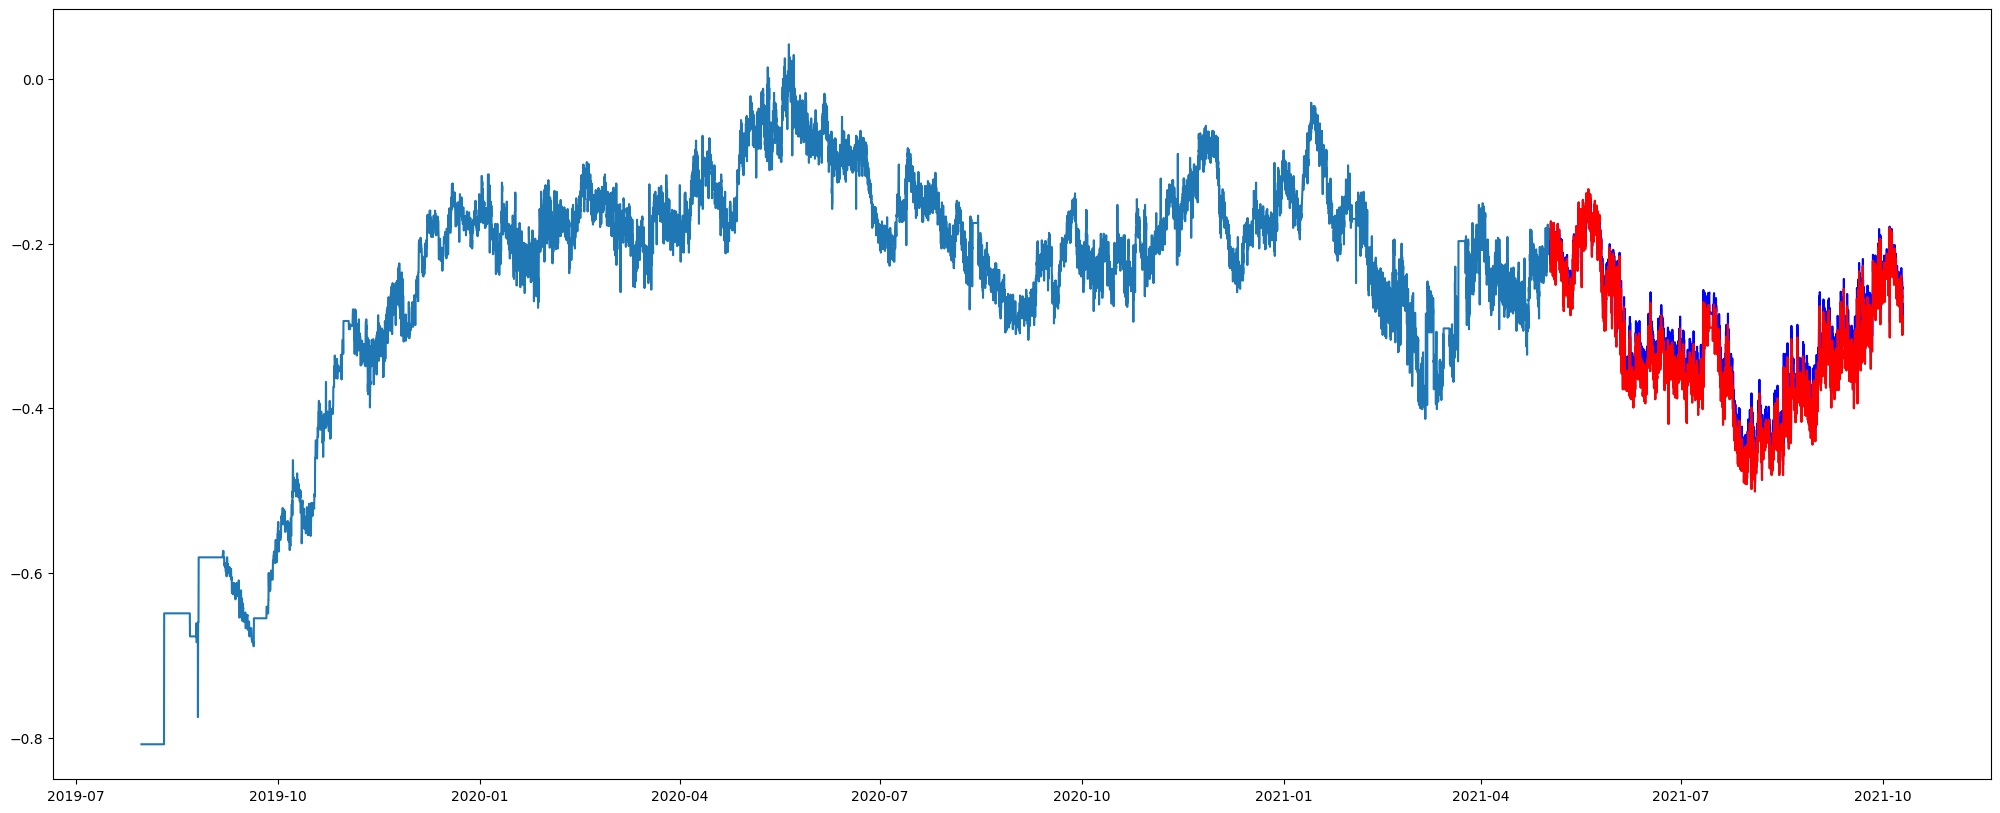

In [ ]:
# run_lstm(impute_nocb)

Trial 25 Complete [00h 00m 22s]
mse: 0.008302468806505203

Best mse So Far: 0.008274207822978497
Total elapsed time: 00h 09m 15s
{'LSTM_1': 50, 'LSTM_2': 40}
Epoch 1/20
241/241 - 5s - loss: 0.0084 - mse: 0.0084 - mae: 0.0550 - mape: 50977.9023 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0681 - val_mape: 12.7252 - 5s/epoch - 22ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0608 - mape: 47307.9492 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0895 - val_mape: 17.2676 - 906ms/epoch - 4ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0590 - mape: 48138.1641 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0992 - val_mape: 19.1781 - 895ms/epoch - 4ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0582 - mape: 49016.3086 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.1025 - val_mape: 19.8334 - 921ms/epoch - 4ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0577 - mape: 49397.8516 - val_loss: 0.

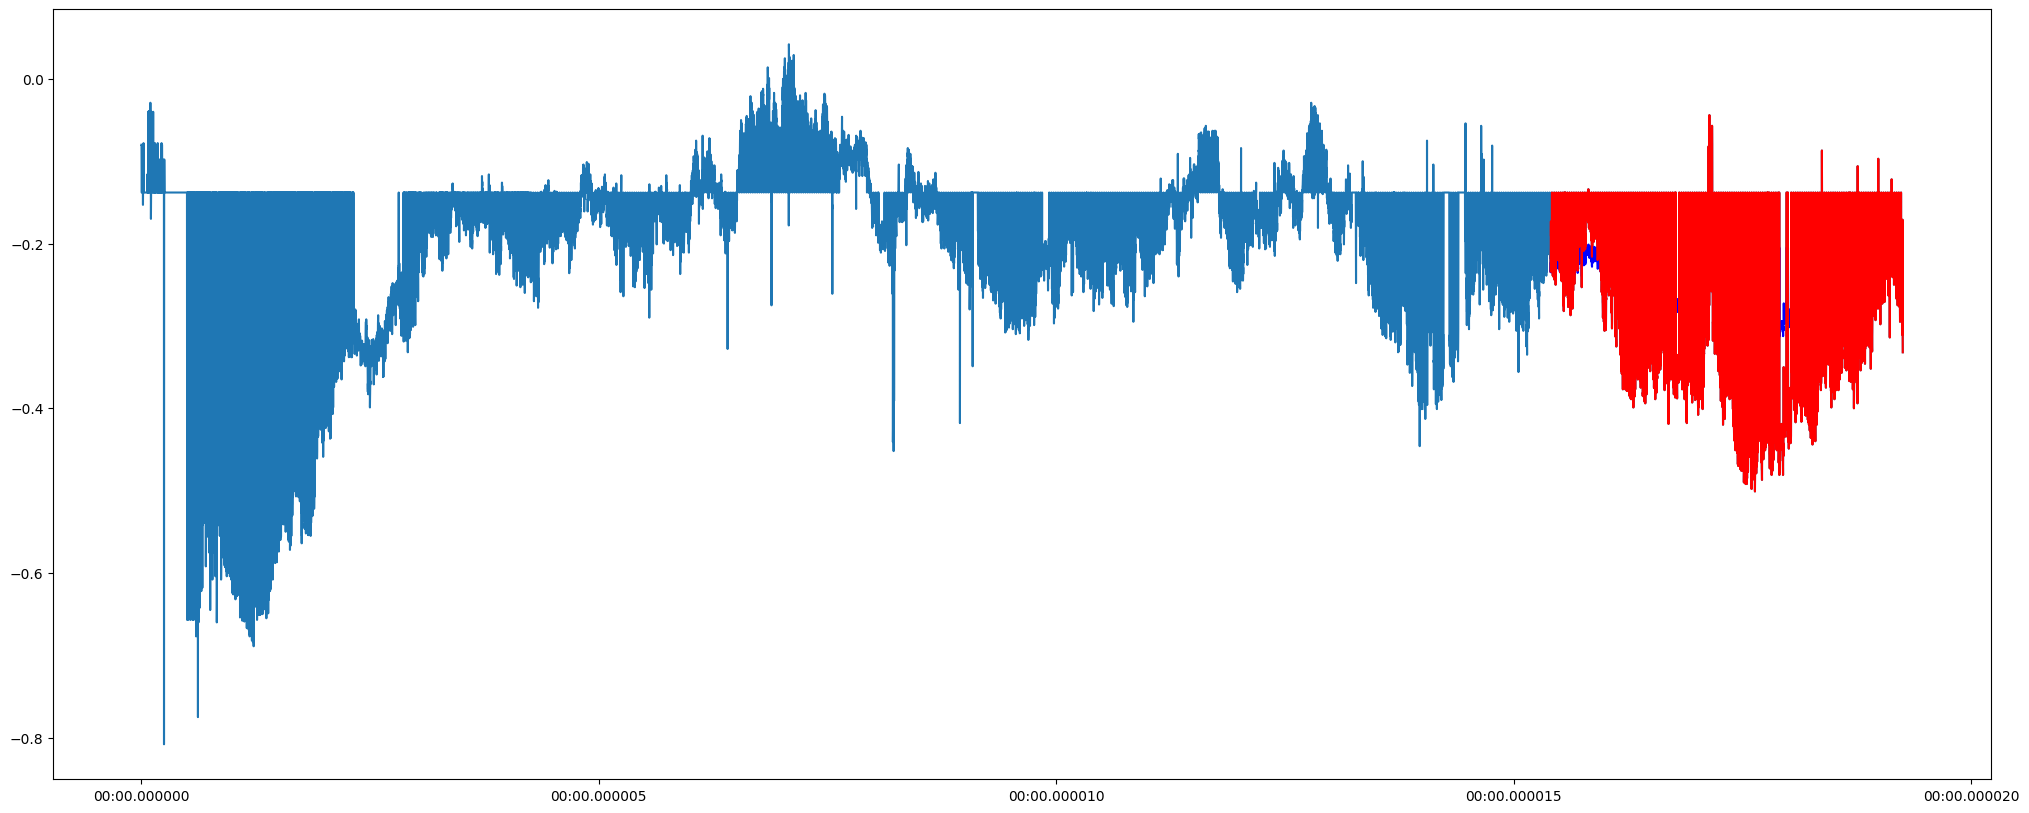

In [23]:
name = 'knn'

best_model, result, val_result = run_lstm_tuning(impute_knn, tuner_name_file=name)

best_model.save('SAVE_MODEL/' + name + '.h5')
result.to_pickle('SAVE_RESULT/' + name + '.pkl')
val_result.to_excel(r'SAVE_VAL/' + name + '.xlsx', index=False)

In [24]:
val_result

,RMSE,R2,MAE,MSE
0,0.089723,0.01266,0.076241,0.00805
